<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2020-11-16 17:00:00+09:00,485,0,180,2020-11-16 17:00:00+09:00
2020-11-17 17:00:00+09:00,391,0,298,2020-11-17 17:00:00+09:00
2020-11-18 17:00:00+09:00,546,0,493,2020-11-18 17:00:00+09:00
2020-11-19 17:00:00+09:00,561,0,534,2020-11-19 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2020-11-16 17:00:00+09:00,485,0,180,2020-11-16 17:00:00+09:00,404.428571,2831.0,0.0,0.0,309.142857,2164.0
2020-11-17 17:00:00+09:00,391,0,298,2020-11-17 17:00:00+09:00,416.000000,2912.0,0.0,0.0,309.857143,2169.0
2020-11-18 17:00:00+09:00,546,0,493,2020-11-18 17:00:00+09:00,440.714286,3085.0,0.0,0.0,335.000000,2345.0
2020-11-19 17:00:00+09:00,561,0,534,2020-11-19 17:00:00+09:00,466.571429,3266.0,0.0,0.0,355.142857,2486.0
2020-11-20 17:00:00+09:00,0,0,522,2020-11-20 17:00:00+09:00,395.571429,2769.0,0.0,0.0,376.285714,2634.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-11-06 17:00:00+09:00,363,0,242,2020-11-06 17:00:00+09:00,388.571429,2720.0,0.0,0.0,180.000000,1260.0,'20w45,Fri
2020-11-07 17:00:00+09:00,480,0,294,2020-11-07 17:00:00+09:00,404.714286,2833.0,0.0,0.0,191.285714,1339.0,'20w45,Sat
2020-11-08 17:00:00+09:00,382,0,189,2020-11-08 17:00:00+09:00,405.142857,2836.0,0.0,0.0,201.714286,1412.0,'20w45,Sun
2020-11-09 17:00:00+09:00,372,0,157,2020-11-09 17:00:00+09:00,403.571429,2825.0,0.0,0.0,211.714286,1482.0,'20w46,Mon
2020-11-10 17:00:00+09:00,310,0,293,2020-11-10 17:00:00+09:00,375.000000,2625.0,0.0,0.0,223.714286,1566.0,'20w46,Tue
2020-11-11 17:00:00+09:00,373,0,317,2020-11-11 17:00:00+09:00,373.000000,2611.0,0.0,0.0,251.571429,1761.0,'20w46,Wed
2020-11-12 17:00:00+09:00,380,0,393,2020-11-12 17:00:00+09:00,380.000000,2660.0,0.0,0.0,269.285714,1885.0,'20w46,Thu
2020-11-13 17:00:00+09:00,497,0,374,2020-11-13 17:00:00+09:00,399.142857,2794.0,0.0,0.0,288.142857,2017.0,'20w46,Fri
2020-11-14 17:00:00+09:00,395,0,352,2020-11-14 17:00:00+09:00,387.000000,2709.0,0.0,0.0,296.428571,2075.0,'20w46,Sat
2020-11-15 17:00:00+09:00,391,0,255,2020-11-15 17:00:00+09:00,388.285714,2718.0,0.0,0.0,305.857143,2141.0,'20w46,Sun


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-10-25 17:00:00+09:00,151.142857,1058
2020-11-01 17:00:00+09:00,169.285714,1185
2020-11-08 17:00:00+09:00,201.714286,1412
2020-11-15 17:00:00+09:00,305.857143,2141
2020-11-20 17:00:00+09:00,405.400000,2027


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-11-06 17:00:00+09:00,363,0,242,2020-11-06 17:00:00+09:00,388.571429,2720.0,0.0,0.0,180.000000,1260.0,'20w45,Fri,NaN,NaN
2020-11-07 17:00:00+09:00,480,0,294,2020-11-07 17:00:00+09:00,404.714286,2833.0,0.0,0.0,191.285714,1339.0,'20w45,Sat,NaN,NaN
2020-11-08 17:00:00+09:00,382,0,189,2020-11-08 17:00:00+09:00,405.142857,2836.0,0.0,0.0,201.714286,1412.0,'20w45,Sun,201.714286,1412.0
2020-11-09 17:00:00+09:00,372,0,157,2020-11-09 17:00:00+09:00,403.571429,2825.0,0.0,0.0,211.714286,1482.0,'20w46,Mon,NaN,NaN
2020-11-10 17:00:00+09:00,310,0,293,2020-11-10 17:00:00+09:00,375.000000,2625.0,0.0,0.0,223.714286,1566.0,'20w46,Tue,NaN,NaN
2020-11-11 17:00:00+09:00,373,0,317,2020-11-11 17:00:00+09:00,373.000000,2611.0,0.0,0.0,251.571429,1761.0,'20w46,Wed,NaN,NaN
2020-11-12 17:00:00+09:00,380,0,393,2020-11-12 17:00:00+09:00,380.000000,2660.0,0.0,0.0,269.285714,1885.0,'20w46,Thu,NaN,NaN
2020-11-13 17:00:00+09:00,497,0,374,2020-11-13 17:00:00+09:00,399.142857,2794.0,0.0,0.0,288.142857,2017.0,'20w46,Fri,NaN,NaN
2020-11-14 17:00:00+09:00,395,0,352,2020-11-14 17:00:00+09:00,387.000000,2709.0,0.0,0.0,296.428571,2075.0,'20w46,Sat,NaN,NaN
2020-11-15 17:00:00+09:00,391,0,255,2020-11-15 17:00:00+09:00,388.285714,2718.0,0.0,0.0,305.857143,2141.0,'20w46,Sun,305.857143,2141.0


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

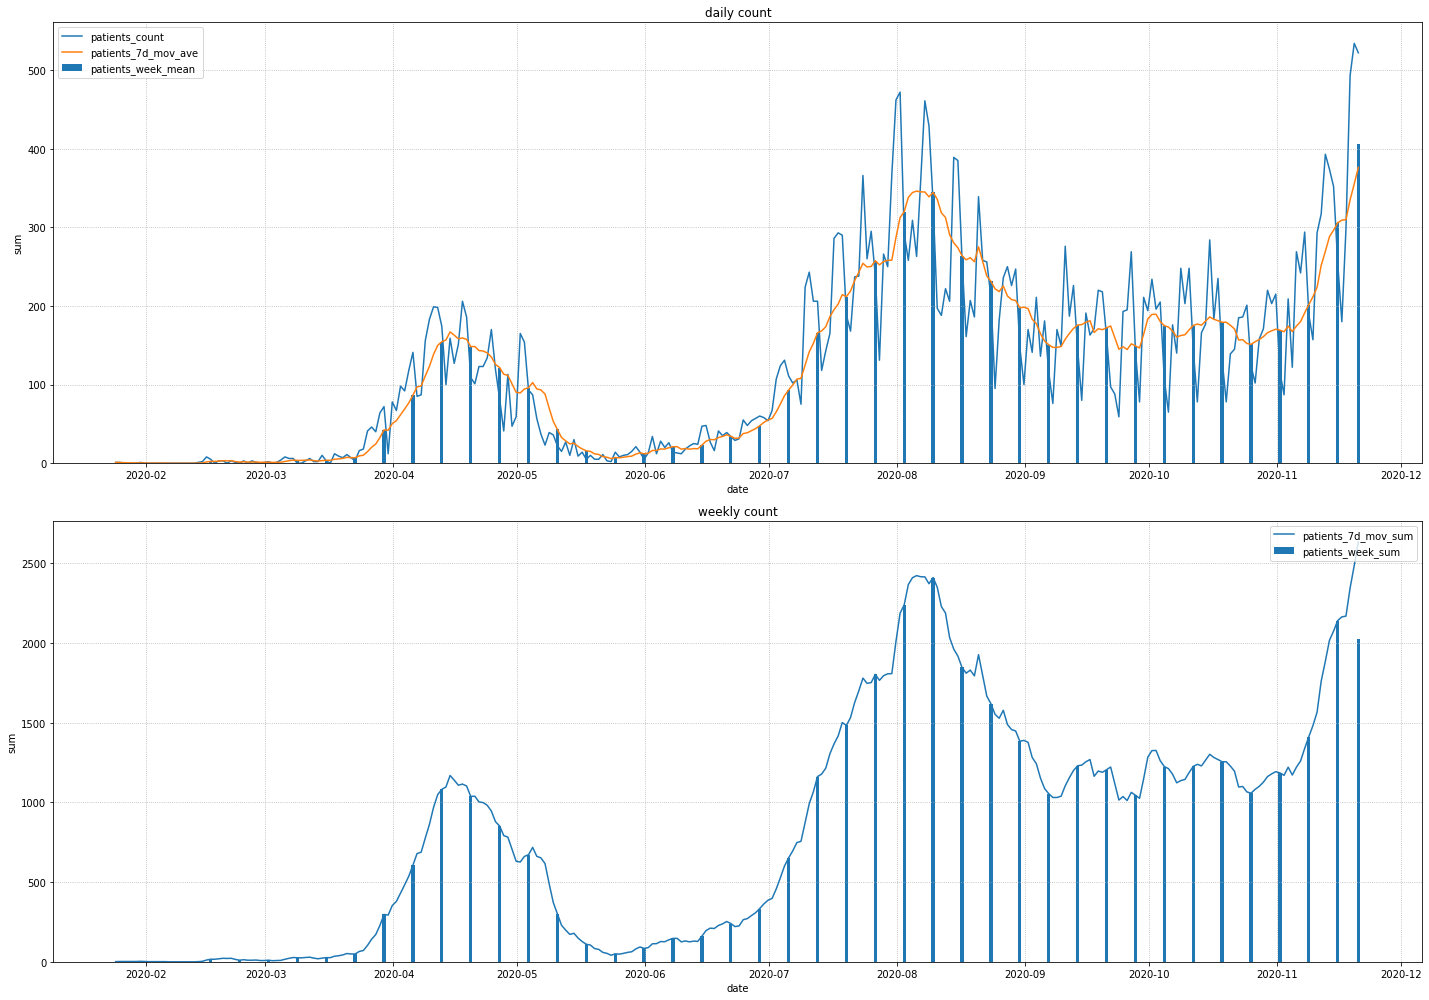

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
287,1.604650e+09,2020,11,6,1,0,0,0,0,0,0,287,0,213,363,388.571429,2720.0,0,0.0,0.0,242,180.000000,1260.0
288,1.604736e+09,2020,11,7,0,0,1,0,0,0,0,288,0,214,480,404.714286,2833.0,0,0.0,0.0,294,191.285714,1339.0
289,1.604822e+09,2020,11,8,0,0,0,1,0,0,0,289,0,215,382,405.142857,2836.0,0,0.0,0.0,189,201.714286,1412.0
290,1.604909e+09,2020,11,9,0,1,0,0,0,0,0,290,0,216,372,403.571429,2825.0,0,0.0,0.0,157,211.714286,1482.0
291,1.604995e+09,2020,11,10,0,0,0,0,0,1,0,291,0,217,310,375.000000,2625.0,0,0.0,0.0,293,223.714286,1566.0
292,1.605082e+09,2020,11,11,0,0,0,0,0,0,1,292,0,218,373,373.000000,2611.0,0,0.0,0.0,317,251.571429,1761.0
293,1.605168e+09,2020,11,12,0,0,0,0,1,0,0,293,0,219,380,380.000000,2660.0,0,0.0,0.0,393,269.285714,1885.0
294,1.605254e+09,2020,11,13,1,0,0,0,0,0,0,294,0,220,497,399.142857,2794.0,0,0.0,0.0,374,288.142857,2017.0
295,1.605341e+09,2020,11,14,0,0,1,0,0,0,0,295,0,221,395,387.000000,2709.0,0,0.0,0.0,352,296.428571,2075.0
296,1.605427e+09,2020,11,15,0,0,0,1,0,0,0,296,0,222,391,388.285714,2718.0,0,0.0,0.0,255,305.857143,2141.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            302 non-null    float64
 1   year                 302 non-null    int64  
 2   month                302 non-null    int64  
 3   day                  302 non-null    int64  
 4   Fri                  302 non-null    uint8  
 5   Mon                  302 non-null    uint8  
 6   Sat                  302 non-null    uint8  
 7   Sun                  302 non-null    uint8  
 8   Thu                  302 non-null    uint8  
 9   Tue                  302 non-null    uint8  
 10  Wed                  302 non-null    uint8  
 11  passed               302 non-null    int64  
 12  emergency            302 non-null    int64  
 13  em_passed            302 non-null    int64  
 14  contacts_count       302 non-null    int64  
 15  contacts_7d_mov_ave  302 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.020000e+02,302.0,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,1.592856e+09,2020.0,6.221854,15.695364,0.145695,0.142384,0.142384,0.142384,0.142384,0.142384,0.142384,150.500000,0.162252,85.688742,763.437086,759.880243,5319.149007,1217.639073,1217.639073,8523.473510,121.781457,117.397966,821.731788
std,7.544803e+06,0.0,2.882030,8.848292,0.353386,0.350024,0.350024,0.350024,0.350024,0.350024,0.350024,87.324109,0.369293,75.314992,487.581210,475.127829,3325.915077,817.577159,649.436074,4546.052521,116.311324,101.666680,711.728996
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.586354e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.250000,0.000000,1.250000,440.500000,447.071429,3129.500000,597.250000,912.750000,6389.250000,13.000000,14.785714,103.500000
50%,1.592856e+09,2020.0,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.500000,0.000000,76.500000,604.500000,621.428571,4350.000000,1252.500000,1213.000000,8491.000000,100.500000,123.928571,867.500000
75%,1.599358e+09,2020.0,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,225.750000,0.000000,151.750000,949.250000,935.571429,6549.000000,1775.500000,1672.250000,11705.750000,196.750000,179.285714,1255.000000
max,1.605859e+09,2020.0,11.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,301.000000,1.000000,227.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,534.000000,376.285714,2634.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,NaN,0.994926,-0.015384,2.320953e-18,-0.002337,-0.011685,-0.007011,0.011685,0.002337,0.007011,1.000000e+00,-0.265023,0.982594,-0.065937,-0.025444,-0.025438,0.144339,0.246335,0.246335,0.685588,0.749399,0.749464
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.949257e-01,NaN,1.000000,-0.115765,-2.484313e-03,-0.001778,-0.011658,-0.005071,0.011396,0.001516,0.008103,9.949257e-01,-0.261803,0.976701,-0.061634,-0.022787,-0.022780,0.143550,0.247142,0.247142,0.685018,0.748169,0.748241
day,-1.538439e-02,NaN,-0.115765,1.000000,2.486647e-02,-0.005257,0.000107,-0.018129,0.002252,0.007615,-0.011693,-1.538439e-02,-0.000074,-0.012895,-0.014188,0.001099,0.001093,0.018108,0.000292,0.000292,-0.039064,-0.036985,-0.037064
Fri,2.320953e-18,NaN,-0.002484,0.024866,1.000000e+00,-0.168268,-0.168268,-0.168268,-0.168268,-0.168268,-0.168268,1.223940e-17,-0.003540,0.003083,-0.028830,-0.009851,-0.009850,0.042935,-0.015108,-0.015108,0.105692,0.008262,0.008213
Mon,-2.336902e-03,NaN,-0.001778,-0.005257,-1.682677e-01,1.000000,-0.166023,-0.166023,-0.166023,-0.166023,-0.166023,-2.336902e-03,0.000596,-0.002598,0.051688,0.000959,0.000961,0.253798,0.002542,0.002542,-0.178681,-0.005392,-0.005381
Sat,-1.168451e-02,NaN,-0.011658,0.000107,-1.682677e-01,-0.166023,1.000000,-0.166023,-0.166023,-0.166023,-0.166023,-1.168451e-02,0.000596,-0.010664,0.036815,-0.001541,-0.001539,-0.285781,0.002542,0.002542,0.098203,-0.011147,-0.011182
Sun,-7.010705e-03,NaN,-0.005071,-0.018129,-1.682677e-01,-0.166023,-0.166023,1.000000,-0.166023,-0.166023,-0.166023,-7.010705e-03,0.000596,-0.006631,-0.010450,-0.000425,-0.000424,-0.263038,0.002542,0.002542,-0.059376,-0.007777,-0.007781
Thu,1.168451e-02,NaN,0.011396,0.002252,-1.682677e-01,-0.166023,-0.166023,-0.166023,1.000000,-0.166023,-0.166023,1.168451e-02,0.000596,0.009752,-0.006459,0.005234,0.005236,0.076407,0.002542,0.002542,0.113871,0.012260,0.012289
Tue,2.336902e-03,NaN,0.001516,0.007615,-1.682677e-01,-0.166023,-0.166023,-0.166023,-0.166023,1.000000,-0.166023,2.336902e-03,0.000596,0.001435,-0.027288,0.002075,0.002076,0.103259,0.002542,0.002542,-0.038811,-0.001427,-0.001406


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1.605514e+09,0,1,0,0,0,0,0,297,0,223,485,0,180,309.142857,2164.0
298,1.605600e+09,0,0,0,0,0,1,0,298,0,224,391,0,298,309.857143,2169.0
299,1.605686e+09,0,0,0,0,0,0,1,299,0,225,546,0,493,335.000000,2345.0
300,1.605773e+09,0,0,0,0,1,0,0,300,0,226,561,0,534,355.142857,2486.0


In [26]:
import seaborn as sns

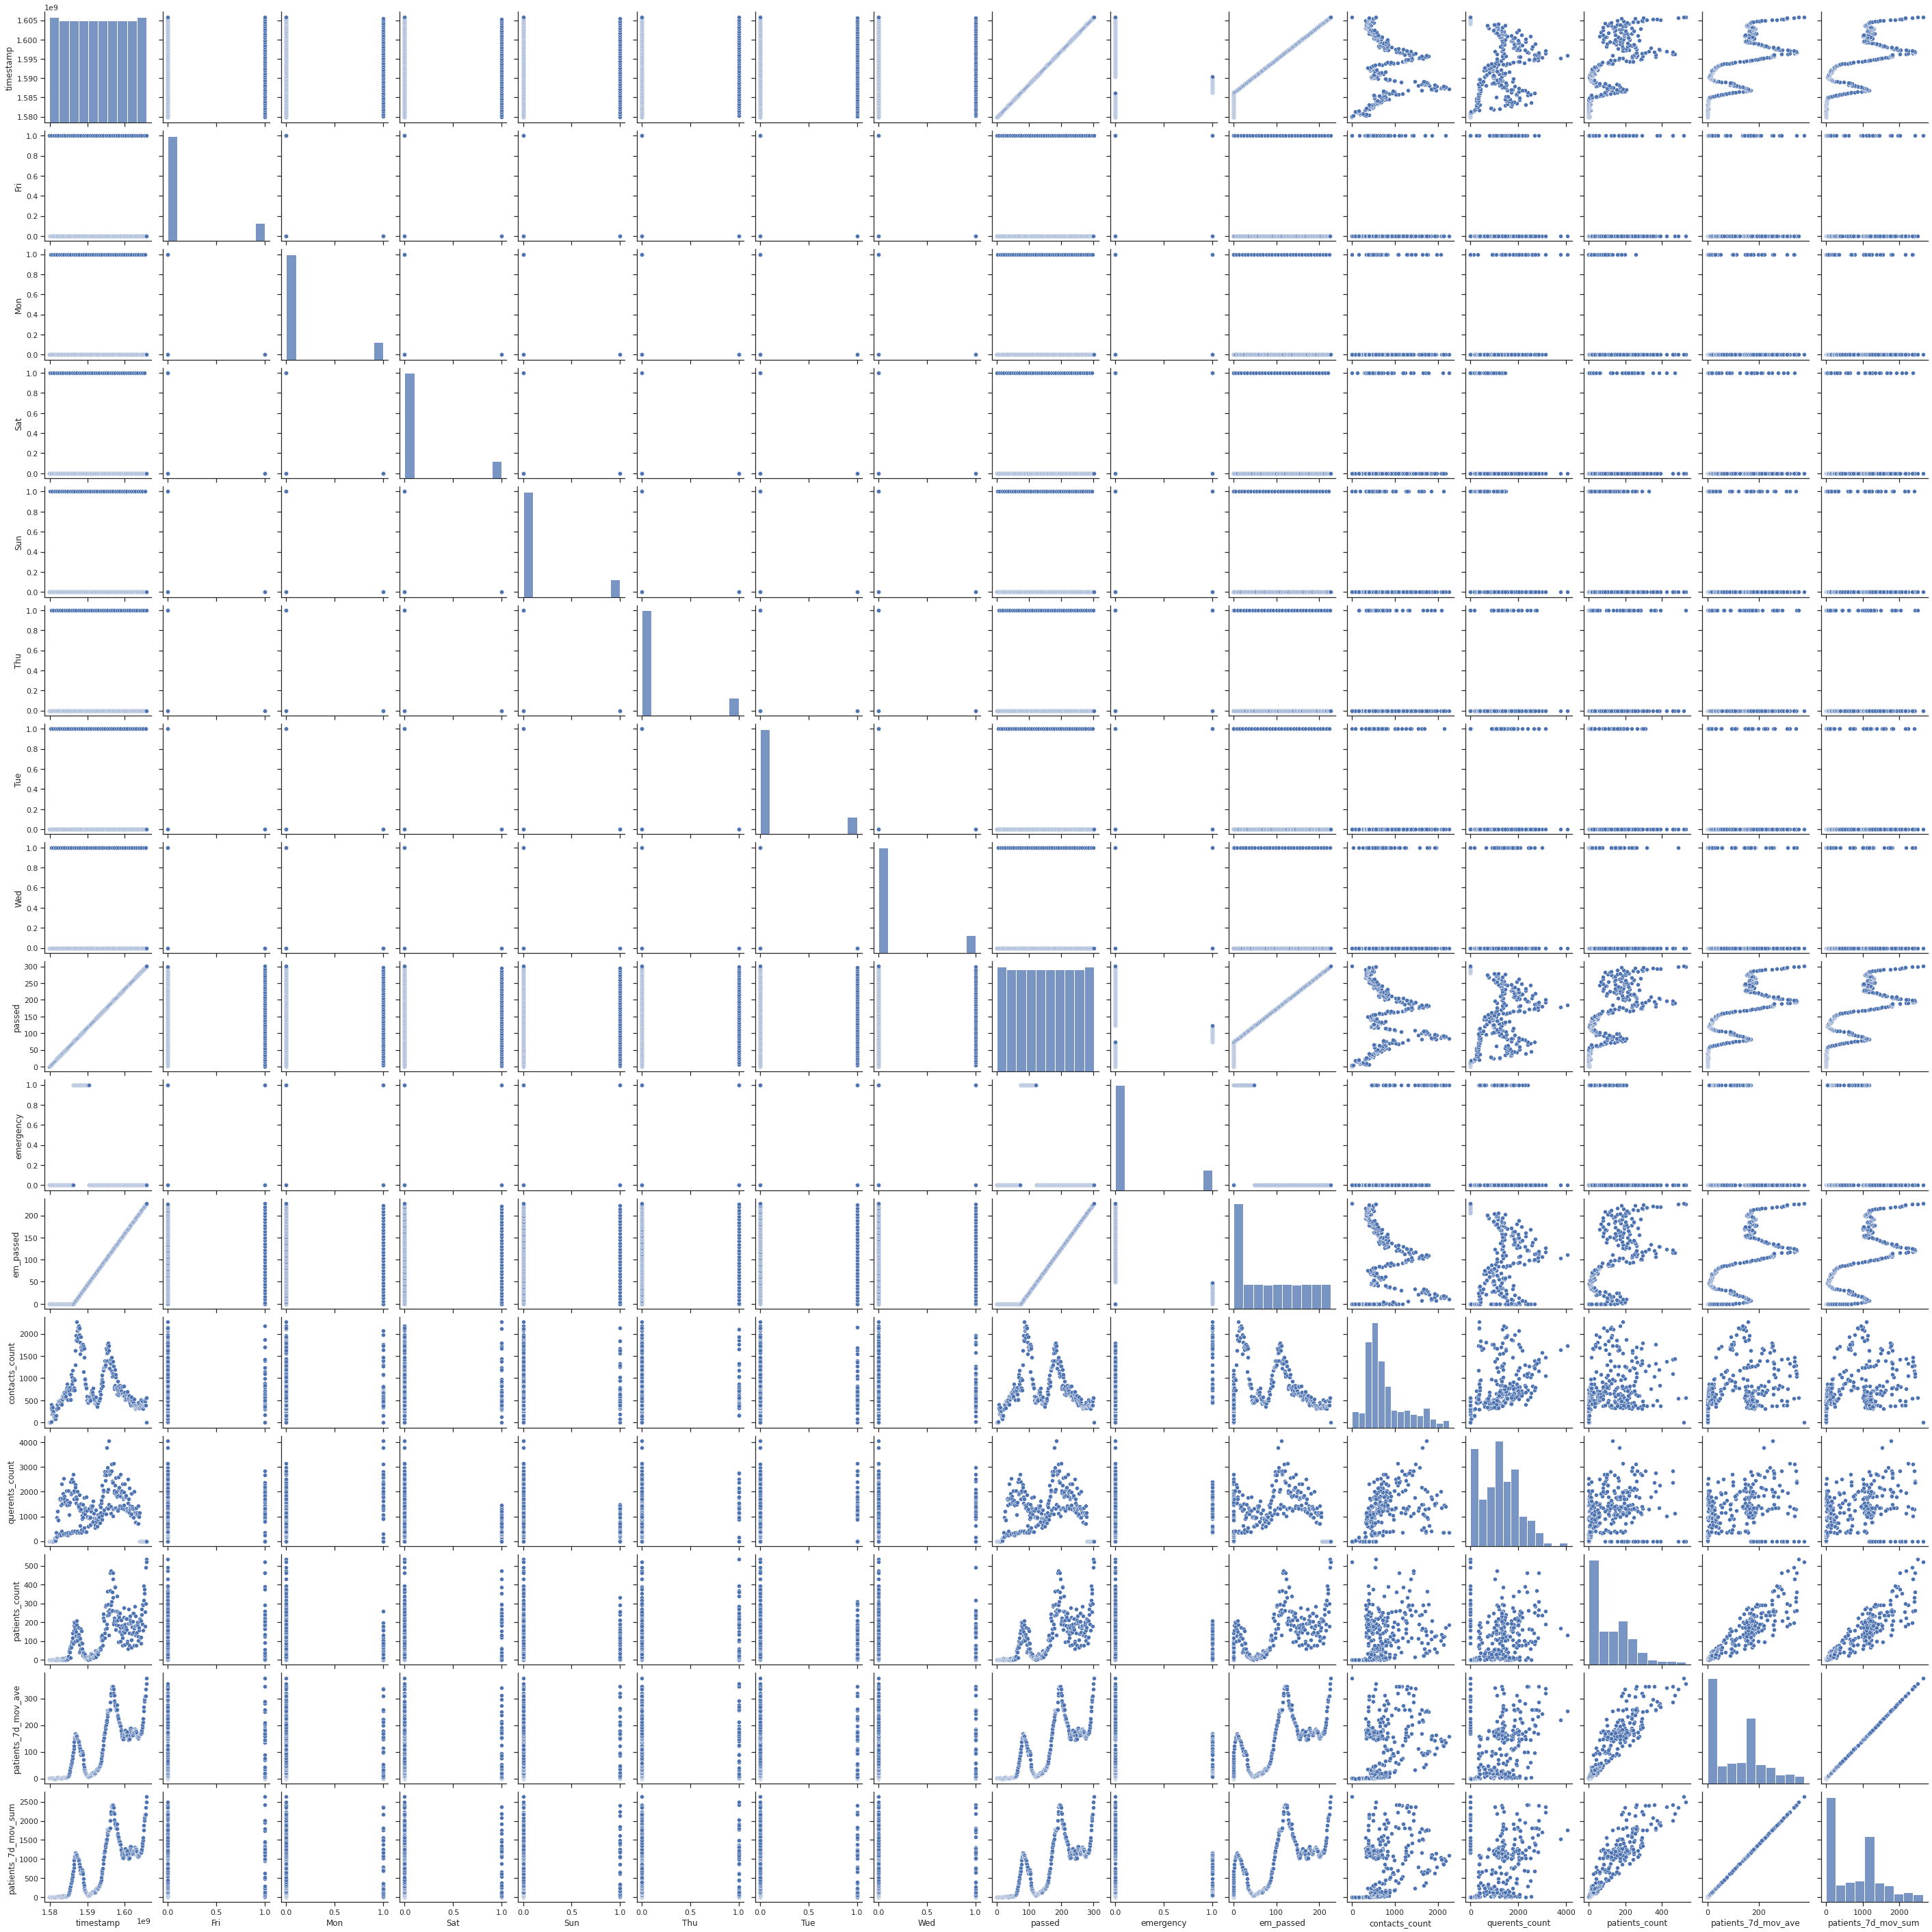

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
